## Objectives:

 * Learn how to add and customize graphical elements to plots
 * Learn techniques for generating publication qualitfy figures

This notebook introduces some advanced plotting techniques for generating publication quality figures.

We'll demonstrate by generating a scatter plot of daily maximum temperatures and relative humidity from the Karachi airport in Pakistan.  This figure will highlight the deadly 2015 heatwave.

In [1]:
""" Initialize the notebook. """
# turn on inline notebook plotting
%matplotlib inline

# import plotting libraries
import pylab as PP
import matplotlib as mpl

#import fastkde (use `pip install fastkde` from the anaconda prompt to install)
#import fastkde.fastKDE as fastKDE # the normal way to import fastKDE
from fastkde import fastKDE # this way of importing fastKDE is particular to Travis's system

# import the netCDF library
import netCDF4 as nc

#import numpy
from numpy import *


# set plot default fonts (fonts that are generally nice for publication quality figures
font = { 'family' : 'serif', \
         'size' : '15', \
         'weight' : 'bold'}
mpl.rc('font', **font)
mpl.rc('axes', labelweight = 'bold') # needed for bold axis labels in more recent version of matplotlib

# define some helper routines
def f_to_c(tf):
    """Converts a temperature in Farenheit to Celsius"""
    
    return (tf - 32.)*5./9.

def c_to_f(tc):
    """Converts a temperature in Celsius to Farenheit"""
    return (9./5.)*tc + 32.

def heat_index(t,r):
    """ Returns the heat index, following https://en.wikipedia.org/wiki/Heat_index.
      
         :param t: temperature [degrees F]
         :param r: relative humidity [percent]
         
         :returns: the heat index
    """
    
    c1 = -42.379
    c2 = 2.04901523
    c3 = 10.14333127
    c4 = -0.22475541
    c5 = -6.83783e-3
    c6 = -5.481717e-2
    c7 = 1.22874e-3
    c8 = 8.5282e-4
    c9 = -1.99e-6
    
    HI = c1 + c2*t + c3*r + c4*t*r + c5*t**2 + c6*r**2 + c7*r*t**2 + c8*t*r**2 + c9*(t**2)*(r**2)
    
    return f_to_c(HI)

In [2]:
""" load the temperature/RH timeseries """
# load the Karachi airport data
# this file can be downloaded from http://taobrienucd.bitbucket.org/data/daily_maxmin_HI_EASM_randomized_hadisd.1.0.3.2014p.417800-99999.nc
with nc.Dataset('../data/daily_maxmin_HI_EASM_randomized_hadisd.1.0.3.2014p.417800-99999.nc','r') as fin:
    t_all = fin.variables['temperature_daily_max'][:] # F
    missing_value = fin.variables['temperature_daily_max'].missing_value
    rh_all = fin.variables['relative_humidity_daily_max'][:] # percent
    time_all = fin.variables['time'][:] # hours since 1973-01-01 00:00:00
    time_units = fin.variables['time'].units
    
#extract only valid data
igood = nonzero(logical_and(t_all != missing_value, rh_all != missing_value))[0]

t = f_to_c(t_all[igood])
rh = rh_all[igood]
time =time_all[igood]

Now we'll generate a simple contour plot.  We've seen plots like this before.

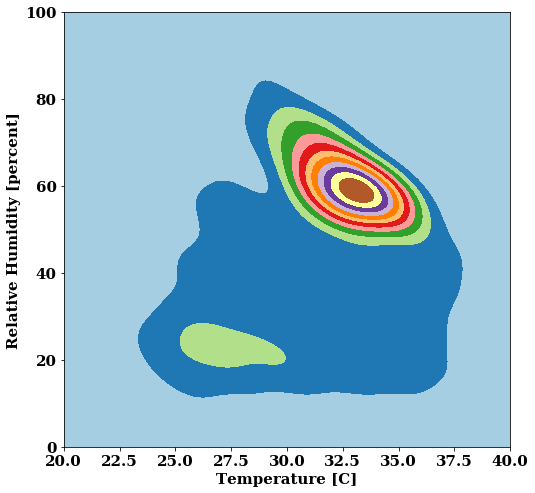

In [3]:
""" calculate and plot the fastKDE of T and RH """

# use fastKDE to calculate the joint probability P(T,RH)
pdf,axes = fastKDE.pdf(t,rh,positiveShift=True,numPoints=[513,513])

# initialize the plot with size 8x8 (not sure of units--I think they are inches)
fig,ax = PP.subplots(figsize=(8,8))

# plot a filled contour plot with 129 levels and using the colormap 'Paired'
# more colormaps can be found at http://matplotlib.org/examples/color/colormaps_reference.html
ax.contourf(axes[0],axes[1],pdf,129,cmap='Paired')

# set plot limits
ax.set_xlim([20,40])
ax.set_ylim([0,100])

#set plot labels
ax.set_xlabel('Temperature [C]')
ax.set_ylabel('Relative Humidity [percent]')
PP.show()

Now that we have this, we'll create a publication quality plot.

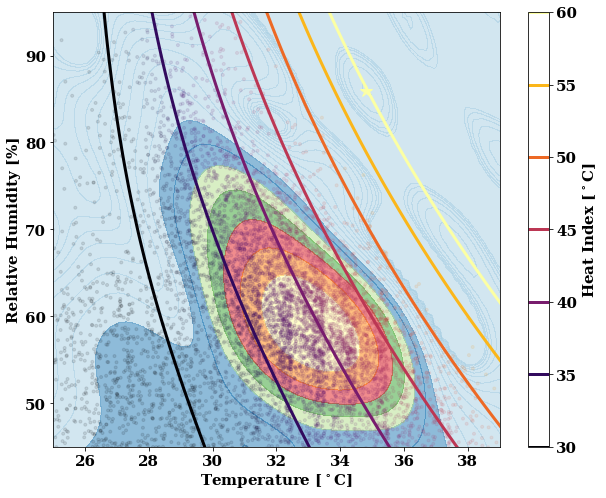

In [4]:
""" replot the joint PDF with the heat index on top"""
# create the plot (make it slightly wider to account for a colorbar on the side; this makes the plot itself ~square)
fig,ax = PP.subplots(figsize=(10,8))

# set contour levels to be logarithmically spaced.  This emphasizes small values
levels = logspace(-5,log10(amax(pdf)),20)
# set the colormap
cmap = mpl.cm.get_cmap('Paired')
# set the fill color for values below the colorbar minimum (the first value of levels) to be the 
# first colormap value ( cmap(0) ) and completely opaque (1.0)
cmap.set_under(cmap(0),1.0)

# generate a contour plot with the above levels and colormap.  Make the filled contours semi-opaque (alpha=0.5)
# the extend='both' is necessary for the set_under() command above to work
cplt1 = ax.contourf(axes[0],axes[1],pdf,levels=levels,cmap=cmap,alpha=0.5,extend='both')

# calculate the heat index
# meshgrid creates two 2D grids of temperature and RH values
# (i.e., every coordinate pair at which the PDF is calculated)
tt,rr = meshgrid(axes[0],axes[1])
# calculate the heat index
HI = heat_index(c_to_f(tt),rr)

# plot the heat index as curves
levels = arange(30,65,5)
# generate a set of contour lines (using contour() instead of contourf()) with the 'inferno' colormap and fat, opaque lines
cplot = ax.contour(axes[0],axes[1],HI,levels=levels,cmap='inferno',linewidths=3,alpha=1)
# turn on contour labels
ax.clabel(cplot,  fontsize=12,fmt='%i')

# plot the individual points
# calculate the heat index of each point
hi_points = heat_index(c_to_f(t),rh)
# make a scatter plot of the points.  the 'c=hi_points' argument makes the dots colored by their heat index using
# the same colormap as the contour lines (notice the use of the cplost object).
ax.scatter(t,rh,c=hi_points,cmap=cplot.cmap,vmin=cplot.vmin,vmax=cplot.vmax,alpha=0.1,marker='.')

# plot the maximum heatindex value as a star
imax = argmax(hi_points)
ax.plot(t[imax],rh[imax],marker='*',markersize=12,color=cplot.cmap(1.0))

# set plot limits
ax.set_xlim([25,39])
ax.set_ylim([45,95])

#set plots labels
ax.set_xlabel('Temperature [$^\circ$C]')
ax.set_ylabel('Relative Humidity [%]')

# add a colorbar representing the heat index colors from the contour lines
fig.colorbar(cplot,ax=ax,label='Heat Index [$^\circ$C]')

# save the figure as a PDF file
PP.savefig('fig_karachi.pdf')

# show the figure
PP.show()